# Data Epoching

Extracting EEG Epoch for each specific tasks

In [1]:
import pandas as pd
import numpy as np

## data filtering

In [2]:
# Define the filtering functions
import scipy.signal as scisig  
def butter_bandpass(low, high, fs, order=4):
    """
    Wrapper function for the scipy butter
    :param low: Frequency to filter above
    :param high: Frequency to filter below
    :param fs: Sampling rate (hz)
    :param order: Order of filter to use (default = 4)
    :return: Numerator (b) and denominator (a) polynomials of the IIR filter
    """
    nyq = 0.5 * fs
    b, a = scisig.butter(order, [low / nyq, high / nyq], btype='band')
    return b, a

def butter_bandpass_filter(data, low, high, fs, order=4):
    """
    Filters passed data with a bandpass butter function
    :param data: data to be bandpass filtered
    :param low: Frequency to filter above
    :param high: Frequency to filter below
    :param fs: Sampling rate (hz)
    :param order: Order of filter to use (default = 4)
    :return: filtered data (and modifies original data).
    """
    b, a = butter_bandpass(low, high, fs, order=order)
    #data = data - np.mean(data)
    return scisig.filtfilt(b, a, data)

In [3]:
# Filter the data
lowpass_value = 1 # Hz
highpass_value = 50 # Hz
fs = 300

# reload data
df = pd.read_csv("data/2018-10-12-preston_walk_raw.csv", ",", skiprows=15)

In [4]:
df.head()

,Time,LE,F4,C4,PO8,PO7,C3,F3,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments
0,0.0033,3642.0,-2536.8,3530.1,2459.4,296.7,3454.5,-1103.4,0,6,0,207,0,Start Data Acquisition
1,0.0067,3635.7,-2526.3,3531.0,2451.9,299.7,3459.6,-1098.9,0,12,0,208,0,NaN
2,0.0100,3632.7,-2535.9,3528.6,2441.4,302.1,3454.8,-1103.4,0,18,0,209,0,NaN
3,0.0133,3626.7,-2535.3,3524.1,2450.1,297.9,3455.1,-1097.1,0,24,0,210,0,NaN
4,0.0167,3626.4,-2527.8,3539.4,2469.0,289.8,3452.7,-1089.9,0,30,0,211,0,NaN


In [11]:
channels = df.columns[1:8]
channels

Index(['LE', 'F4', 'C4', 'PO8', 'PO7', 'C3', 'F3'], dtype='object')

In [5]:
from mne.filter import filter_data
low = 1
high = 40
filtered = filter_data(df[df.columns[1:8]].values.T, fs, low, high)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 991 samples (3.303 sec) selected


Event | Task
------|------
5   | Typing
6   | Talking
7   | Walking

The order is 7 -> 5 -> 6 ->7

First, get the indices

In [6]:
typing_index = df.loc[df['Event'] == 5].index[0]
talking_index = df.loc[df['Event'] == 6].index[0]
walking_index = df.loc[df['Event'] == 7].index
walking_1 = walking_index[0]
walking_2 = walking_index[1]

## Extract EEG

In [7]:
buffer = 1 * fs

In [8]:
first_walking = df.loc[walking_1 + buffer : typing_index - buffer]
typing = df.loc[typing_index + buffer : talking_index - buffer]
talking = df.loc[talking_index + buffer : walking_2 - buffer]
second_walking = df.loc[walking_2 + buffer: len(df) - buffer]

## Inspect Spectrograms

In [9]:
from matplotlib.pyplot import specgram

(array([[1.24191651e+04, 1.14108173e+04, 1.02825803e+04, ...,
         4.61347005e+06, 4.59865879e+06, 4.59861243e+06],
        [6.43614052e+03, 5.91328885e+03, 5.36111299e+03, ...,
         2.34731040e+06, 2.33497269e+06, 2.34140798e+06],
        [1.32387370e+00, 5.15447063e+00, 6.32524846e-01, ...,
         4.19564200e+01, 9.85523945e+00, 4.04985287e+01],
        ...,
        [4.65572319e-01, 1.31080388e+00, 2.84398622e+00, ...,
         1.99203877e-01, 2.14810824e-01, 7.49616315e-01],
        [1.84882929e-01, 1.04886767e+00, 1.81255640e+00, ...,
         1.11353665e+00, 6.65441255e-01, 6.47297951e-01],
        [3.76681669e-01, 3.26681339e-01, 2.28134843e-02, ...,
         1.63736917e+00, 8.50899589e-01, 1.90965700e-01]]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,

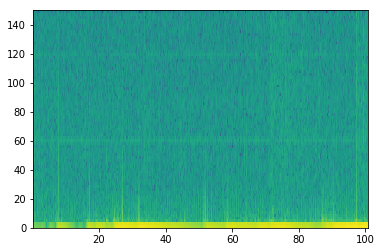

In [10]:
specgram(typing.F4, Fs=fs, NFFT=fs//2)